# Modeling Wpdx + Environmental Data using XGBoost

In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import necessary libraries

In [85]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline



### Read and explore the data

In [86]:
df = pd.read_csv(r'../data/processed/wpdx_processed.csv')
df.head()




,row_id,source,lat_deg,lon_deg,report_date,status_id,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
0,215873,Evidence Action,0.174668,34.554572,2023-02-11T00:00:00.000,Yes,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,...,4.914062,5.804299,11.215961,0.7685,0.77920,0.765850,23.35,23.620,24.402727,10.462028
1,215240,Evidence Action,0.220830,34.565483,2023-11-15T00:00:00.000,Yes,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,...,3.862696,5.864281,11.359583,0.7642,0.77615,0.745817,23.63,23.370,24.260909,6.315442
2,194605,Evidence Action,0.044235,34.339775,2023-11-15T00:00:00.000,Yes,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,...,2.113567,2.798805,7.549499,0.7348,0.73455,0.716650,24.89,24.350,24.922000,5.745561
3,219017,Evidence Action,-0.449933,34.794163,2023-11-17T00:00:00.000,Yes,Borehole/Tubewell,Well,NaN,NaN,...,2.045830,2.790391,7.499787,0.7235,0.73420,0.730017,24.41,24.310,24.433636,3.103306
4,587740,USAID/KEA KIWASH,0.497160,34.831463,2021-02-05T00:00:00.000,No,Undefined Well,Well,Public Tapstand,Public Tapstand,...,4.075452,5.655031,9.077165,0.7256,0.74335,0.711867,23.79,23.435,24.326000,7.758868


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 85 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   row_id                      21368 non-null  int64  
 1   source                      21368 non-null  object 
 2   lat_deg                     21368 non-null  float64
 3   lon_deg                     21368 non-null  float64
 4   report_date                 21368 non-null  object 
 5   status_id                   21368 non-null  object 
 6   water_source_clean          21342 non-null  object 
 7   water_source_category       21342 non-null  object 
 8   water_tech_clean            15937 non-null  object 
 9   _water_tech_category        15787 non-null  object 
 10  facility_type               21368 non-null  object 
 11  clean_country_name          21368 non-null  object 
 12  clean_country_id            21368 non-null  object 
 13  clean_adm1                  213

## Data Cleaning and Preprocessing

### Null values

In [88]:
# check null values
null_columns = df.columns[df.isnull().any()]
if not null_columns.empty:
    print("Columns with null values:")
    print(df[null_columns].isnull().sum())
else:
    print("There are no null values in the DataFrame.")   
    

Columns with null values:
water_source_clean               26
water_source_category            26
water_tech_clean               5431
_water_tech_category           5581
clean_adm4                    21368
install_year                  14965
installer                     16343
rehab_year                    21368
rehabilitator                 21368
management_clean              14970
pay_clean                     20563
fecal_coliform_presence       21368
fecal_coliform_value          21368
subjective_quality_clean      14949
activity_id                     504
scheme_id                     21368
notes                         20606
orig_lnk                      20557
photo_lnk                     14949
country_id                       14
distance_to_city                 10
local_population                202
served_population               202
rehab_priority                18837
_pop_who_would_gain_access    18899
crucialness                     222
pressure                        438
us

### Deal with missing values

- so many missing values 
- lets drop the columns where (entirely missing, metadata, irrelevant for modelling)

In [89]:
# Drop columns with 0 usable data
drop_cols = [
    'clean_adm4', 'rehab_year', 'rehabilitator',
    'fecal_coliform_presence', 'fecal_coliform_value',
    'scheme_id', 'pay_clean', 'pay', 'notes', 'orig_lnk',
    'is_duplicate', 'photo_lnk', 'installer', 'converted',
    'subjective_quality', 'subjective_quality_clean'
]

# Drop metadata or duplicative fields
meta_cols = [
    'report_date', 'row_id', 'source', 'activity_id', 'pt_id', 'data_lnk',
    'country_id', 'status_id', 'new_georeferenced_column_',
    'lat_lon_deg', 'created_timestamp', 'updated', 'dataset_title',
    'water_point_history', 'orig_lnk', 'photo_lnk', 'public_data_source'
]
df.drop(columns=drop_cols + meta_cols, inplace=True, errors='ignore')

df.head()

,lat_deg,lon_deg,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_country_name,clean_country_id,clean_adm1,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
0,0.174668,34.554572,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,4.914062,5.804299,11.215961,0.7685,0.77920,0.765850,23.35,23.620,24.402727,10.462028
1,0.220830,34.565483,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,3.862696,5.864281,11.359583,0.7642,0.77615,0.745817,23.63,23.370,24.260909,6.315442
2,0.044235,34.339775,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Siaya,...,2.113567,2.798805,7.549499,0.7348,0.73455,0.716650,24.89,24.350,24.922000,5.745561
3,-0.449933,34.794163,Borehole/Tubewell,Well,NaN,NaN,Improved,Kenya,KEN,Homa Bay,...,2.045830,2.790391,7.499787,0.7235,0.73420,0.730017,24.41,24.310,24.433636,3.103306
4,0.497160,34.831463,Undefined Well,Well,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Kakamega,...,4.075452,5.655031,9.077165,0.7256,0.74335,0.711867,23.79,23.435,24.326000,7.758868


In [90]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   lat_deg                     21368 non-null  float64
 1   lon_deg                     21368 non-null  float64
 2   water_source_clean          21342 non-null  object 
 3   water_source_category       21342 non-null  object 
 4   water_tech_clean            15937 non-null  object 
 5   _water_tech_category        15787 non-null  object 
 6   facility_type               21368 non-null  object 
 7   clean_country_name          21368 non-null  object 
 8   clean_country_id            21368 non-null  object 
 9   clean_adm1                  21368 non-null  object 
 10  clean_adm2                  21368 non-null  object 
 11  clean_adm3                  21368 non-null  object 
 12  install_year                6403 non-null   float64
 13  management_clean            639

In [91]:
# Drop high-missing-value columns (> 30% missing)
high_missing_cols = df.isnull().mean()
drop_cols = high_missing_cols[high_missing_cols > 0.3].index

df = df.drop(columns=drop_cols)

# Drop rows missing critical categorical columns
essential_cat_cols = [
    'water_source_clean',
    'water_source_category',
    'water_tech_clean',
    '_water_tech_category',
    'facility_type'
]

df = df.dropna(subset=essential_cat_cols)

# Fill missing values in numeric columns with the median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing values in categorical columns with the mode
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# Final check
print("Remaining missing values per column:")
print(df.isnull().sum().sort_values(ascending=False))


Remaining missing values per column:
lat_deg                    0
latitude                   0
location_id                0
is_urban                   0
cluster_size               0
country_name               0
water_source               0
adm1                       0
adm2                       0
adm3                       0
count                      0
longitude                  0
staleness_score            0
chirps_7_precipitation     0
chirps_30_precipitation    0
chirps_90_precipitation    0
ndvi_7_NDVI                0
ndvi_30_NDVI               0
ndvi_90_NDVI               0
lst_7_LST_Day_1km          0
lst_30_LST_Day_1km         0
lst_90_LST_Day_1km         0
is_latest                  0
days_since_report          0
lon_deg                    0
clean_adm3                 0
water_source_clean         0
water_source_category      0
water_tech_clean           0
_water_tech_category       0
facility_type              0
clean_country_name         0
clean_country_id           0
clean_

In [92]:
df_cleaned = df.copy()

df_cleaned.head()

,lat_deg,lon_deg,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_country_name,clean_country_id,clean_adm1,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
0,0.174668,34.554572,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,4.914062,5.804299,11.215961,0.7685,0.77920,0.765850,23.35,23.620,24.402727,10.462028
1,0.220830,34.565483,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,3.862696,5.864281,11.359583,0.7642,0.77615,0.745817,23.63,23.370,24.260909,6.315442
2,0.044235,34.339775,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Siaya,...,2.113567,2.798805,7.549499,0.7348,0.73455,0.716650,24.89,24.350,24.922000,5.745561
4,0.497160,34.831463,Undefined Well,Well,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Kakamega,...,4.075452,5.655031,9.077165,0.7256,0.74335,0.711867,23.79,23.435,24.326000,7.758868
5,0.134735,34.687273,Protected Well,Well,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Kakamega,...,5.567590,5.462062,10.701967,0.7659,0.77880,0.763500,23.73,23.325,24.079091,9.620794


In [93]:
df_cleaned.shape

(15761, 47)

In [94]:
print(df_cleaned.dtypes)


lat_deg                    float64
lon_deg                    float64
water_source_clean          object
water_source_category       object
water_tech_clean            object
_water_tech_category        object
facility_type               object
clean_country_name          object
clean_country_id            object
clean_adm1                  object
clean_adm2                  object
clean_adm3                  object
status_clean                object
distance_to_primary        float64
distance_to_secondary      float64
distance_to_tertiary       float64
distance_to_city           float64
distance_to_town           float64
local_population           float64
served_population          float64
crucialness                float64
pressure                   float64
usage_cap                  float64
days_since_report            int64
staleness_score            float64
is_latest                     bool
location_id                  int64
is_urban                      bool
cluster_size        

In [95]:
# Categorical columns
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        print(f"\nColumn: {col}")
        print(df_cleaned[col].unique())



Column: water_source_clean
['Protected Well' 'Undefined Well' 'Borehole/Tubewell' 'Piped Water'
 'Sand or Sub-surface Dam' 'Unprotected Well' 'Rainwater Harvesting'
 'Protected Spring' 'Delivered Water']

Column: water_source_category
['Well' 'Piped Water' 'Sand or Sub-surface Dam' 'Rainwater Harvesting'
 'Spring' 'Delivered Water']

Column: water_tech_clean
['Motorized Pump - Electric' 'Public Tapstand' 'Motorized Pump'
 'Hand Pump - Afridev' 'Hand Pump' 'Hand Pump - India Mark'
 'Hand Pump - Nira' 'Hand Pump - Blue' 'Hand Pump - Tara'
 'Rope and Bucket' 'Motorized Pump - Diesel' 'Hand Pump - Rope'
 'Hand Pump - SWN 80']

Column: _water_tech_category
['Motorized Pump' 'Public Tapstand' 'Hand Pump' 'Rope and Bucket']

Column: facility_type
['Improved' 'Improved - Other']

Column: clean_country_name
['Kenya']

Column: clean_country_id
['KEN']

Column: clean_adm1
['Kakamega' 'Siaya' 'Migori' 'Makueni' 'Busia' 'Kiambu' 'Embu' 'Kisumu'
 'Nyamira' 'Vihiga' 'Samburu' 'Homa Bay' 'Bungoma' 'K

### Duplicates

In [96]:
df_cleaned[df_cleaned.duplicated(subset=['latitude', 'longitude'], keep=False)].sort_values(by=['latitude', 'longitude'])


,lat_deg,lon_deg,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_country_name,clean_country_id,clean_adm1,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
6425,0.027583,34.792957,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.394601,4.261939,10.177632,0.7500,0.76610,0.772883,23.73,22.970,23.128182,7.322334
6426,0.027583,34.792957,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.394601,4.261939,10.177632,0.7500,0.76610,0.772883,23.73,22.970,23.128182,7.322334
6427,0.027583,34.792957,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.394601,4.261939,10.177632,0.7500,0.76610,0.772883,23.73,22.970,23.128182,7.322334
6428,0.027583,34.792957,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.394601,4.261939,10.177632,0.7500,0.76610,0.772883,23.73,22.970,23.128182,7.322334
6429,0.027583,34.792957,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.394601,4.261939,10.177632,0.7500,0.76610,0.772883,23.73,22.970,23.128182,7.322334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14698,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.759900,24.19,24.065,23.824000,5.037134
14699,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.759900,24.19,24.065,23.824000,5.037134
14700,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.759900,24.19,24.065,23.824000,5.037134
14701,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.759900,24.19,24.065,23.824000,5.037134


- the duplicate entries for identical latitude and longitude are completely identical across all relevant features

`We will drop because`:

- All numeric and categorical values match exactly.

- No temporal metadata (e.g., timestamp or year) is included.

- Repetition is likely the result of data duplication rather than meaningful sampling.


In [97]:
# Check for duplicates based on latitude and longitude
duplicates_geo = df_cleaned.duplicated(subset=['latitude', 'longitude'])

# Count duplicates
print("Duplicate locations:", duplicates_geo.sum())

# View duplicate rows
df_cleaned[duplicates_geo]


Duplicate locations: 12282


,lat_deg,lon_deg,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_country_name,clean_country_id,clean_adm1,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
5091,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.7599,24.19,24.065,23.824000,5.037134
5092,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.7599,24.19,24.065,23.824000,5.037134
5093,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.7599,24.19,24.065,23.824000,5.037134
5094,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.7599,24.19,24.065,23.824000,5.037134
5095,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.7599,24.19,24.065,23.824000,5.037134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20951,0.169940,34.724442,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,6.867427,6.798100,13.159847,0.7592,0.76785,0.7380,23.49,22.990,23.071818,6.440071
20952,0.169940,34.724442,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,6.867427,6.798100,13.159847,0.7592,0.76785,0.7380,23.49,22.990,23.071818,6.440071
20953,0.169940,34.724442,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,6.867427,6.798100,13.159847,0.7592,0.76785,0.7380,23.49,22.990,23.071818,6.440071
20954,0.169940,34.724442,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,6.867427,6.798100,13.159847,0.7592,0.76785,0.7380,23.49,22.990,23.071818,6.440071


In [98]:
df_cleaned = df_cleaned.drop_duplicates(subset=['latitude', 'longitude'])


In [99]:
unique_points = df_cleaned[['latitude', 'longitude']].drop_duplicates()
print(f"Unique water point locations: {len(unique_points)}")


Unique water point locations: 3479


In [100]:
df_cleaned

,lat_deg,lon_deg,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_country_name,clean_country_id,clean_adm1,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
0,0.174668,34.554572,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,4.914062,5.804299,11.215961,0.7685,0.77920,0.765850,23.35,23.620,24.402727,10.462028
1,0.220830,34.565483,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,3.862696,5.864281,11.359583,0.7642,0.77615,0.745817,23.63,23.370,24.260909,6.315442
2,0.044235,34.339775,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Siaya,...,2.113567,2.798805,7.549499,0.7348,0.73455,0.716650,24.89,24.350,24.922000,5.745561
4,0.497160,34.831463,Undefined Well,Well,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Kakamega,...,4.075452,5.655031,9.077165,0.7256,0.74335,0.711867,23.79,23.435,24.326000,7.758868
5,0.134735,34.687273,Protected Well,Well,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Kakamega,...,5.567590,5.462062,10.701967,0.7659,0.77880,0.763500,23.73,23.325,24.079091,9.620794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21362,0.121658,34.464638,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Siaya,...,5.734777,4.933049,9.900964,0.7782,0.78920,0.783067,24.21,23.745,24.664545,6.986204
21363,0.061087,34.842942,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.985360,5.431612,11.764437,0.7765,0.78705,0.758450,23.01,22.475,22.620909,9.863127
21364,0.028658,34.525814,Protected Well,Well,Hand Pump,Hand Pump,Improved,Kenya,KEN,Siaya,...,3.931248,3.760260,9.639885,0.6940,0.69380,0.715567,24.19,23.805,23.826364,4.242080
21365,-0.671726,37.738338,Sand or Sub-surface Dam,Sand or Sub-surface Dam,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Embu,...,0.716135,0.397227,3.169620,0.5827,0.62535,0.689267,24.27,24.895,24.513636,0.640961


In [101]:
df_cleaned.columns

Index(['lat_deg', 'lon_deg', 'water_source_clean', 'water_source_category',
       'water_tech_clean', '_water_tech_category', 'facility_type',
       'clean_country_name', 'clean_country_id', 'clean_adm1', 'clean_adm2',
       'clean_adm3', 'status_clean', 'distance_to_primary',
       'distance_to_secondary', 'distance_to_tertiary', 'distance_to_city',
       'distance_to_town', 'local_population', 'served_population',
       'crucialness', 'pressure', 'usage_cap', 'days_since_report',
       'staleness_score', 'is_latest', 'location_id', 'is_urban',
       'cluster_size', 'country_name', 'water_source', 'adm1', 'adm2', 'adm3',
       'count', 'latitude', 'longitude', 'chirps_7_precipitation',
       'chirps_30_precipitation', 'chirps_90_precipitation', 'ndvi_7_NDVI',
       'ndvi_30_NDVI', 'ndvi_90_NDVI', 'lst_7_LST_Day_1km',
       'lst_30_LST_Day_1km', 'lst_90_LST_Day_1km', 'pop_population'],
      dtype='object')

### clean columns

- pruning decision based on each correlated pair
1. Perfect Duplicates: Keep 'latitude', 'longitude' 
2. NDVI, LST, CHIRPS, Pressure & Served Population
- keep only the 30 day because it is more interpretable
- keep served_population and pressure
3. Keep: 'staleness_score'
4. remove 'days_since_report' and 'location_id' 
5. LST- Drop All are dropped due to leakage/correlation
6. pressure	- drop due to label leakage
7. 'usage_cap', 'cluster_size' - same values might introduce noise

In [102]:
drop_cols = [
    # Perfect duplicates
    'lat_deg', 'lon_deg',

    # Redundant country info
    'country_name', 'clean_country_name', 'clean_country_id',

    # ID and temporal leakage
    'location_id', 'days_since_report', 'count',
    
    # Redundant administrative variables
    'adm1', 'adm2', 'adm3',

    # Redundant short-term environmental variables
    'chirps_7_precipitation', 'chirps_90_precipitation',
    'ndvi_7_NDVI', 'ndvi_90_NDVI',
    'lst_7_LST_Day_1km', 'lst_90_LST_Day_1km',

    # Leakage or low signal
    'usage_cap', 'cluster_size',
    
    # Redundant 
    'water_source', '_water_tech_category', 'facility_type', 'is_latest', 'is_urban'
    
]
df_cleaned = df_cleaned.drop(columns=drop_cols)
df_cleaned.columns

Index(['water_source_clean', 'water_source_category', 'water_tech_clean',
       'clean_adm1', 'clean_adm2', 'clean_adm3', 'status_clean',
       'distance_to_primary', 'distance_to_secondary', 'distance_to_tertiary',
       'distance_to_city', 'distance_to_town', 'local_population',
       'served_population', 'crucialness', 'pressure', 'staleness_score',
       'latitude', 'longitude', 'chirps_30_precipitation', 'ndvi_30_NDVI',
       'lst_30_LST_Day_1km', 'pop_population'],
      dtype='object')

## Predict Risk Score as a Multiclass Classification Problem

`pop_population`: Higher density → greater likelihood of contamination due to overuse or stress on infrastructure.

`pressure`: Lower pressure can lead to backflow or intrusion of contaminants; hence, high pressure might seem better, but if paired with population and temperature, it may still signal risk.

`lst_30_LST_Day_1km`: Higher surface temperature promotes microbial growth and water quality deterioration.



### Proxy target variable

In [103]:
# Risk Score Label 
# -  combines population density, water pressure, and surface temperature—three known risk-related features—to estimate contamination risk. 

df_cleaned['risk_score'] = (
    (df_cleaned['pop_population'] > df_cleaned['pop_population'].median()).astype(int) +
    (df_cleaned['pressure'] > df_cleaned['pressure'].median()).astype(int) +
    (df_cleaned['lst_30_LST_Day_1km'] > df_cleaned['lst_30_LST_Day_1km'].median()).astype(int)
)


In [104]:
df_cleaned['risk_score'].value_counts()

risk_score
1    1644
2    1376
0     244
3     215
Name: count, dtype: int64

`Interpretation of Each Score`:

0 = All three features are below or equal to the median → lowest estimated risk.

1 = Only one feature is above the median → slightly elevated risk.

2 = Two features are above the median → moderately elevated risk.

3 = All three features are above the median → highest estimated risk.

### Correlation

In [105]:
# correlations with 'risk_score'
correlations = df_cleaned.corr(numeric_only=True)['risk_score']

# Filter features with strong correlation
strong_corr = correlations[(correlations > 0.7) | (correlations < -0.7)]

print(strong_corr)


risk_score    1.0
Name: risk_score, dtype: float64


In [106]:
# copy of the cleaned df
df_model = df_cleaned.copy()
df_model.head()

,water_source_clean,water_source_category,water_tech_clean,clean_adm1,clean_adm2,clean_adm3,status_clean,distance_to_primary,distance_to_secondary,distance_to_tertiary,...,crucialness,pressure,staleness_score,latitude,longitude,chirps_30_precipitation,ndvi_30_NDVI,lst_30_LST_Day_1km,pop_population,risk_score
0,Protected Well,Well,Motorized Pump - Electric,Kakamega,Khwisero,Kisa Central,Non-Functional,9183.615388,429.841197,6642.740054,...,0.092552,0.836667,85.472443,0.174668,34.554572,5.804299,0.77920,23.620,10.462028,1
1,Protected Well,Well,Motorized Pump - Electric,Kakamega,Butere,Marama North,Non-Functional,9834.545269,3503.282125,1517.239132,...,0.055234,0.413333,93.270891,0.220830,34.565483,5.864281,0.77615,23.370,6.315442,1
2,Protected Well,Well,Motorized Pump - Electric,Siaya,Alego Usonga,South East Alego,Non-Functional,12946.140250,399.848815,5794.867044,...,0.199682,1.676667,93.270891,0.044235,34.339775,2.798805,0.73455,24.350,5.745561,3
4,Undefined Well,Well,Public Tapstand,Kakamega,Malava,Butali/Chegulo,"Non-Functional, dry season",24860.727495,20338.383954,4072.968360,...,0.314988,3.033333,67.775251,0.497160,34.831463,5.655031,0.74335,23.435,7.758868,2
5,Protected Well,Well,Public Tapstand,Kakamega,Ikolomani,Idakho South,"Functional, not in use",13949.830321,1275.321026,1183.524036,...,0.090775,1.230000,67.604558,0.134735,34.687273,5.462062,0.77880,23.325,9.620794,2


In [107]:
df_model.dtypes

water_source_clean          object
water_source_category       object
water_tech_clean            object
clean_adm1                  object
clean_adm2                  object
clean_adm3                  object
status_clean                object
distance_to_primary        float64
distance_to_secondary      float64
distance_to_tertiary       float64
distance_to_city           float64
distance_to_town           float64
local_population           float64
served_population          float64
crucialness                float64
pressure                   float64
staleness_score            float64
latitude                   float64
longitude                  float64
chirps_30_precipitation    float64
ndvi_30_NDVI               float64
lst_30_LST_Day_1km         float64
pop_population             float64
risk_score                   int32
dtype: object

### Features and target

In [108]:
X = df_model.drop(columns=['risk_score', 'pop_population', 'pressure', 'lst_30_LST_Day_1km'])
y = df_model['risk_score']  # Values: 0, 1, 2, 3

### Train-test split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Preprocessor

In [110]:
# Column types
numeric_cols = X.select_dtypes(include='number').columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

## Baseline Model: Logistic Regression

In [111]:
# Create pipeline
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
logreg_pipeline.fit(X_train, y_train)

# Predict
y_pred = logreg_pipeline.predict(X_test)

# Print evaluation report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

c:\Users\PINCHEZZ\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.53      0.55        45
           1       0.71      0.78      0.74       351
           2       0.65      0.62      0.63       260
           3       0.59      0.25      0.35        40

    accuracy                           0.67       696
   macro avg       0.63      0.55      0.57       696
weighted avg       0.67      0.67      0.67       696



Accuracy: 67%

Weighted F1: 0.66

Weakest macro recall: 0.54

Most confusion: class 3 vs 2.

In [112]:
print(confusion_matrix(y_test, y_pred))


[[ 24  20   1   0]
 [ 16 274  61   0]
 [  3  89 161   7]
 [  0   5  25  10]]


Class 1 is the majority class and shows decent performance.

Class 3 (high risk) is poorly classified: only 10 of 40 are correct (25% recall).

Many class 3 samples are misclassified as class 2.


## Tuned Logistic Regression

In [113]:
from scipy.stats import loguniform

# Parameter space
param_distributions = {
    'classifier__C': loguniform(0.001, 10.0),
    'classifier__penalty': ['l2']
}

# Randomized search
random_search = RandomizedSearchCV(
    logreg_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Predictions
best_logistic_model = random_search.best_estimator_
y_pred = best_logistic_model.predict(X_test)

# Evaluation
print("Best Parameters:", random_search.best_params_)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix (raw values)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\PINCHEZZ\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Best Parameters: {'classifier__C': 6.351221010640703, 'classifier__penalty': 'l2'}

Classification Report:

              precision    recall  f1-score   support

           0       0.45      0.53      0.49        45
           1       0.70      0.76      0.73       351
           2       0.65      0.61      0.63       260
           3       0.52      0.28      0.36        40

    accuracy                           0.66       696
   macro avg       0.58      0.54      0.55       696
weighted avg       0.66      0.66      0.66       696


Confusion Matrix:
 [[ 24  20   1   0]
 [ 26 267  58   0]
 [  3  89 158  10]
 [  0   3  26  11]]


No significant improvement from baseline.
Still weak performance for class 3 (only 12/40).

Weighted F1: 0.66

Accuracy: 66%

Very slight improvement in hyperparameter tuning, but overall performance stagnates.

## Untuned XGBoost Classifier

In [114]:
# Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42))
])

# Fit
xgb_pipeline.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.66      0.60      0.63        45
           1       0.84      0.87      0.86       351
           2       0.81      0.80      0.81       260
           3       0.69      0.55      0.61        40

    accuracy                           0.81       696
   macro avg       0.75      0.71      0.73       696
weighted avg       0.81      0.81      0.81       696



Accuracy: 81%

Weighted F1: 0.81

Weighted Recall: 0.81

Macro Recall: 0.71

In [115]:
print(confusion_matrix(y_test, y_pred_xgb))


[[ 27  18   0   0]
 [ 12 307  31   1]
 [  2  41 208   9]
 [  0   1  17  22]]


Much stronger across all classes.

Class 3 recall improves (22/40).

Class 1 performance is solid: 307/351 correct (87%).

However, still some minor confusion in class 2 and 3.

## Tuned XGBoost (RandomizedSearchCV)

In [116]:
# parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 1, 5]
}

# Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        eval_metric='mlogloss',
        random_state=42
    ))
])

# Randomized Search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit search
random_search.fit(X_train, y_train)

# Best model
best_xgb_model = random_search.best_estimator_

# Predict
y_pred = best_xgb_model.predict(X_test)

# Evaluation
print("Best Parameters:", random_search.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Summary metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"\n🔹 Accuracy: {acc:.4f}")
print(f"🔹 Weighted F1 Score: {f1:.4f}")
print(f"🔹 Weighted Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 1.0}
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        45
           1       0.83      0.87      0.85       351
           2       0.80      0.82      0.81       260
           3       0.81      0.53      0.64        40

    accuracy                           0.81       696
   macro avg       0.77      0.69      0.72       696
weighted avg       0.81      0.81      0.81       696


🔹 Accuracy: 0.8103
🔹 Weighted F1 Score: 0.8072
🔹 Weighted Recall: 0.8103

Confusion Matrix:
 [[ 25  20   0   0]
 [ 13 305  33   0]
 [  1  41 213   5]
 [  0   0  19  21]]


`Interpretation`:

Class 3 correctly identified 21/40 times.

Performance in class 1 and 2 is nearly optimal.

Slight drop in class 0 accuracy (from 27 → 25).

`Metrics`:

Accuracy: 81%

Weighted F1: 0.8072

Macro Recall: 0.69

`Comment`:

Model generalizes well, but confusion between class 0 and 1 persists

## SMOTE + XGBoost 

In [117]:
# SMOTE + XGBoost pipeline
smote_xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])


# Fit the model
smote_xgb_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = smote_xgb_pipeline.predict(X_test)

# Compute metrics
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Output
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Recall: {recall:.4f}")

c:\Users\PINCHEZZ\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.

c:\Users\PINCHEZZ\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:13:41] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Confusion Matrix:
 [[ 32  13   0   0]
 [ 19 299  32   1]
 [  1  38 212   9]
 [  0   0  15  25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.66        45
           1       0.85      0.85      0.85       351
           2       0.82      0.82      0.82       260
           3       0.71      0.62      0.67        40

    accuracy                           0.82       696
   macro avg       0.75      0.75      0.75       696
weighted avg       0.82      0.82      0.82       696

Accuracy: 0.8161
Weighted F1 Score: 0.8164
Weighted Recall: 0.8161


`Interpretation`:

Best performance on class 0: 32/45.

Class 3 recall improves to 62.5% (25/40).

Overall better balance across all classes.

`Metrics`:

Accuracy: 81.6%

Weighted F1: 0.8164

Macro avg F1: 0.75

Macro avg Recall: 0.75

`Comment`:

SMOTE increased representation of minority classes during training. Model learned more balanced class boundaries, especially improving minority class 3.




# Model Interpretation 

- Tabular comparison of our models

| Model # | Model Type          | Accuracy  | Weighted F1 | Class 3 Recall | Best For                    |
| ------- | ------------------- | --------- | ----------- | -------------- | --------------------------- |
| 1       | Logistic (Baseline) | 0.67      | 0.66        | 25%            | Basic linear modeling       |
| 2       | Logistic (Tuned)    | 0.66      | 0.66        | 30%            | Slightly better tuning      |
| 3       | XGBoost (Untuned)   | 0.81      | 0.81        | 55%            | Stronger nonlinear splits   |
| 4       | XGBoost (Tuned)     | 0.81      | 0.81        | 53%            | Optimized tree params       |
| **5**   | **SMOTE + XGBoost** | **0.816** | **0.816**   | **62.5%**      | **Balanced class handling** |


- the best-performing model is the tuned SMOTE + XGBoost

`why`:

Highest F1 and accuracy.

Most balanced recall across all classes.

Robust class 3 performance.

Trained on resampled data to reduce bias from class imbalance.

### Basic Feature Importance

In [118]:
# Extract trained smote + XGBoost model
xgb_model = smote_xgb_pipeline.named_steps['model']

# Get feature importances
importances = xgb_model.feature_importances_

# Get feature names from preprocessor
feature_names = smote_xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

# importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Top 15 important features
print(importance_df.head(15))


                                             feature  importance
19   cat__water_source_clean_Sand or Sub-surface Dam    0.047094
6                             num__served_population    0.029059
534                          cat__clean_adm3_Sitikho    0.028994
418                          cat__clean_adm3_Maralal    0.026977
129                          cat__clean_adm2_Matungu    0.022790
49                            cat__clean_adm1_Kisumu    0.021823
427                           cat__clean_adm3_Masaba    0.019453
60                           cat__clean_adm1_Samburu    0.018443
5                              num__local_population    0.018350
54                            cat__clean_adm1_Migori    0.017967
32            cat__water_tech_clean_Hand Pump - Nira    0.017678
271                         cat__clean_adm3_Gitothua    0.017315
10                                    num__longitude    0.016171
145                           cat__clean_adm2_Nyando    0.016111
222                   cat

Geographic location (adm1, adm2, adm3 features) dominates the feature importance list.

Technology and source type (e.g., sand dam, pump type) are also significant.

Population size (both local and served) are key numeric indicators.


### SHAP for Deep Interpretability:

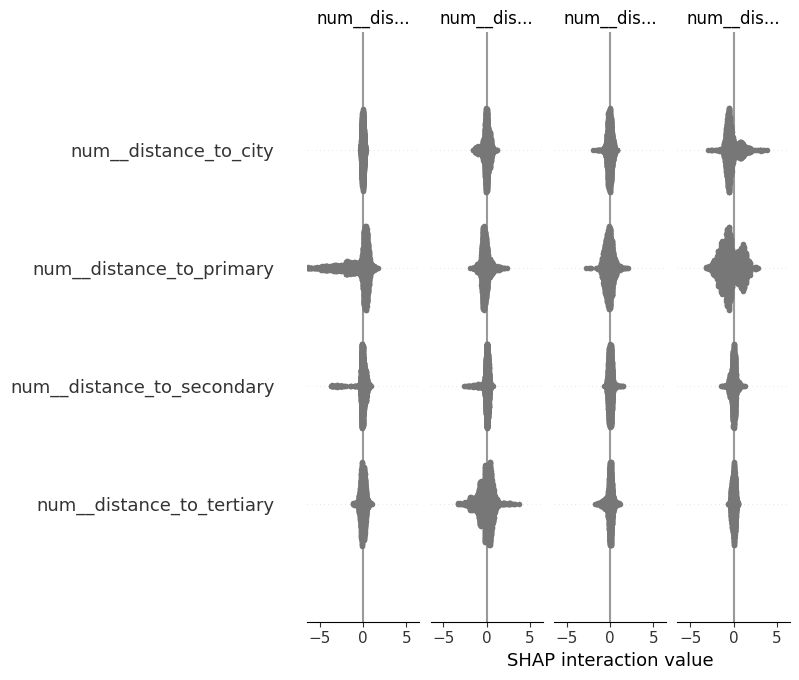

In [119]:
import shap

# SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Transform training data through the pipeline
X_transformed = smote_xgb_pipeline.named_steps['preprocessor'].transform(X_train)

# SHAP values
shap_values = explainer.shap_values(X_transformed)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


`Observations`:

Most top features are numeric and tied to geography (lat/lon), `population`, `environmental conditions`, and distance.

The model heavily relies on `population` (served and local), supporting our proxy label design.

Categorical features like water source type and location codes (adm1, adm2, adm3) also matter, but less than environmental/numeric ones.

### Risk Classification Map (Geospatial Visualization)
- Using Plotly

In [120]:
import plotly.express as px

fig = px.scatter_mapbox(
    df_model,
    lat="latitude",
    lon="longitude",
    color="risk_score",
    size_max=10,
    zoom=6,
    mapbox_style="carto-positron",
    color_continuous_scale="RdYlGn_r",
    hover_data=['clean_adm1', 'clean_adm2', 'water_source_clean'],
)

fig.update_layout(title="Kenya Water Points Risk Map", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


C:\Users\PINCHEZZ\AppData\Local\Temp\ipykernel_6536\25570390.py:3: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



`Conclusion`

Our model shows well-grounded and interpretable, relevant drivers of water risk.

Using logical features like served population and environmental indicators.

Showing reasonable balance across classes (especially Class 1 & 2), with less influence from any single class bias.

This model is ready for deployment and communication with stakeholders.

## Save the Cleaned Dataframe for Streamlit


In [121]:
df_model

,water_source_clean,water_source_category,water_tech_clean,clean_adm1,clean_adm2,clean_adm3,status_clean,distance_to_primary,distance_to_secondary,distance_to_tertiary,...,crucialness,pressure,staleness_score,latitude,longitude,chirps_30_precipitation,ndvi_30_NDVI,lst_30_LST_Day_1km,pop_population,risk_score
0,Protected Well,Well,Motorized Pump - Electric,Kakamega,Khwisero,Kisa Central,Non-Functional,9183.615388,429.841197,6642.740054,...,0.092552,0.836667,85.472443,0.174668,34.554572,5.804299,0.77920,23.620,10.462028,1
1,Protected Well,Well,Motorized Pump - Electric,Kakamega,Butere,Marama North,Non-Functional,9834.545269,3503.282125,1517.239132,...,0.055234,0.413333,93.270891,0.220830,34.565483,5.864281,0.77615,23.370,6.315442,1
2,Protected Well,Well,Motorized Pump - Electric,Siaya,Alego Usonga,South East Alego,Non-Functional,12946.140250,399.848815,5794.867044,...,0.199682,1.676667,93.270891,0.044235,34.339775,2.798805,0.73455,24.350,5.745561,3
4,Undefined Well,Well,Public Tapstand,Kakamega,Malava,Butali/Chegulo,"Non-Functional, dry season",24860.727495,20338.383954,4072.968360,...,0.314988,3.033333,67.775251,0.497160,34.831463,5.655031,0.74335,23.435,7.758868,2
5,Protected Well,Well,Public Tapstand,Kakamega,Ikolomani,Idakho South,"Functional, not in use",13949.830321,1275.321026,1183.524036,...,0.090775,1.230000,67.604558,0.134735,34.687273,5.462062,0.77880,23.325,9.620794,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21362,Protected Well,Well,Motorized Pump - Electric,Siaya,Gem,North Gem,Non-Functional,1345.634133,7620.128495,5790.024513,...,0.082958,1.043333,93.683404,0.121658,34.464638,4.933049,0.78920,23.745,6.986204,1
21363,Protected Well,Well,Motorized Pump - Electric,Vihiga,Hamisi,Banja,Non-Functional,17786.013257,5625.748836,292.492573,...,0.113972,1.003333,84.667991,0.061087,34.842942,5.431612,0.78705,22.475,9.863127,1
21364,Protected Well,Well,Hand Pump,Siaya,Gem,East Gem,"Functional, not in use",6065.989535,3013.631233,3036.850910,...,0.174757,0.960000,67.711191,0.028658,34.525814,3.760260,0.69380,23.805,4.242080,0
21365,Sand or Sub-surface Dam,Sand or Sub-surface Dam,Public Tapstand,Embu,Mbeere South,Kiambere,"Functional, not in use",10092.638514,12162.181670,2364.380776,...,0.311927,1.156667,24.803437,-0.671726,37.738338,0.397227,0.62535,24.895,0.640961,1


In [122]:
# Save the DataFrame 
df_model.to_csv(r'../data/processed/environmental.csv', index=False)

# Save the best model for deployment

In [123]:
import joblib

# Save the full pipeline model (with preprocessor)
joblib.dump(smote_xgb_pipeline, r'../models/environmental.pkl')


['../models/environmental.pkl']

In [124]:
# load the model

# model = joblib.load(r'../models/environmental.pkl')
# predictions = model.predict(new_data)

In [126]:
import sklearn
from pathlib import Path
print("Scikit-learn version used to save:", sklearn.__version__)

# Path to save
model_path = Path("../models/environmental.pkl")
joblib.dump(smote_xgb_pipeline, model_path)

# Immediately load back and test
model = joblib.load(model_path)
print("Model loaded successfully.")

Scikit-learn version used to save: 1.6.1
Model loaded successfully.
